# 4th go:
- construct basis from Gaussian + derivatives
- fit time-series of CCFs in that way
- look at time-dependence of coefficients

Suzanne Aigrain @ Oxford, June 2019

In [1]:
%pylab inline
import pickle
from scipy.optimize import minimize
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


### Read in solar data

In [2]:
def read_ccfs(years = ['2015','2016','2017','2018'], doPlot = True):
    for i, year in enumerate(years):
        with open('../data/HARPN_Sun/ccf_'+year,'rb') as infile:
            if i == 0:
                ccfs = pickle.load(infile)
                nobs,nvel = np.shape(ccfs)
                crval1 = -20
                cdelt1 = 0.25
                vel = np.arange(nvel)*cdelt1 + crval1
            else:
                ccfs = np.concatenate([ccfs, pickle.load(infile)])
    if doPlot:
        plt.figure(figsize=(16,6))
        ccfRef = np.mean(ccfs,axis=0)
        plt.imshow((ccfs - ccfRef).T)
    return vel, ccfs

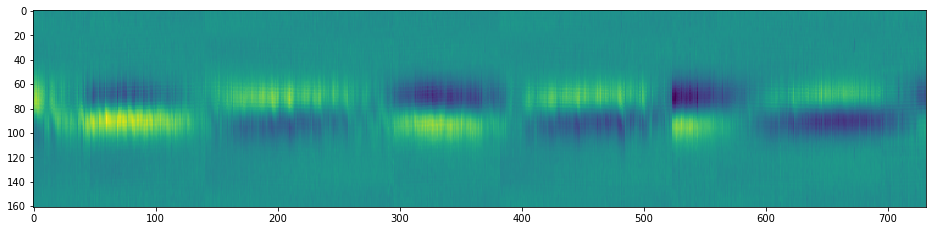

In [3]:
vels, ccfs = read_ccfs()

In [40]:
def read_ts(years = ['2015','2016','2017','2018'], doPlot=True):
    for i, year in enumerate(years):
        with open('../data/HARPN_Sun/vel_'+year,'rb') as infile:
            velYear = pickle.load(infile)
        if i == 0:
            bjd = velYear[:,0]
            rvh = velYear[:,1]
            bsrv = velYear[:,2]
            fwhm = velYear[:,3]
            cont = velYear[:,4]
            bis = velYear[:,5]
            yr = np.zeros_like(bjd).astype('int') + int(year)
            tsall = np.copy(velYear)
        else:
            bjd = np.concatenate([bjd,velYear[:,0]]).flatten()
            rvh = np.concatenate([rvh,velYear[:,1]]).flatten()
            bsrv = np.concatenate([bsrv,velYear[:,2]]).flatten()
            fwhm = np.concatenate([fwhm,velYear[:,3]]).flatten()
            cont = np.concatenate([cont,velYear[:,4]]).flatten()
            bis = np.concatenate([bis,velYear[:,5]]).flatten()
            yy = np.zeros_like(velYear[:,0]).astype('int') + int(year)
            yr = np.concatenate([yr,yy]).flatten()
            tsall = np.concatenate([tsall,velYear])
    rvb = rvh - bsrv
    print(tsall.shape)
    np.savetxt('HARPSN_Solar_TS.txt',tsall)
    if doPlot:
        fig, axes = plt.subplots(5,1,figsize=(15,10),sharex=True)
        axes[0].plot(bjd,rvb,'k.')
        axes[1].plot(bjd,rvh,'k.')
        axes[2].plot(bjd,fwhm,'k.')
        axes[3].plot(bjd,cont,'k.')
        axes[4].plot(bjd,bis,'k.')
        axes[0].set_ylabel('bary RV')
        axes[1].set_ylabel('helio RV')
        axes[2].set_ylabel('FWHM')
        axes[2].set_ylim(6.98,7.02)
        axes[3].set_ylabel('Contrast')
        axes[3].set_ylim(45.5,46.5)
        axes[4].set_ylabel('BIS')
        axes[4].set_ylim(-0.03,-0.01)
    return yr, bjd, rvh, bsrv, rvb, fwhm, cont, bis

(732, 6)


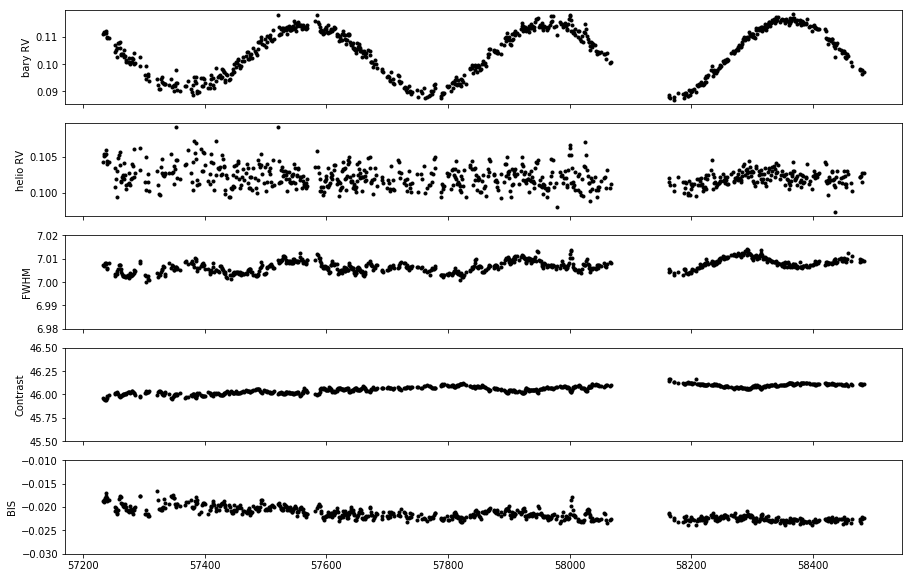

In [41]:
yr, bjd, rvh, bsrv, rvb, fwhm, cont, bis = read_ts()

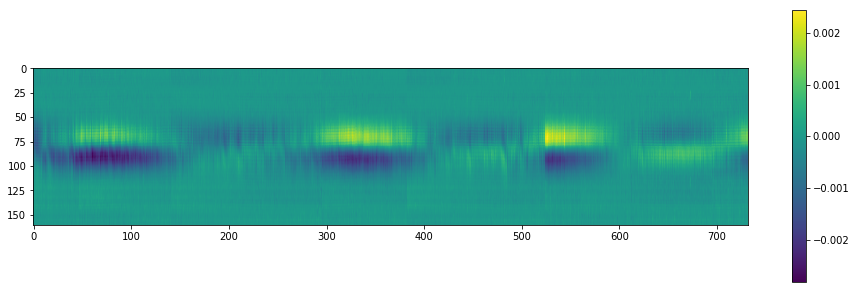

In [6]:
iref = 601
x = vels
y = 1 - ccfs
yref = y[iref,:]
plt.figure(figsize=(16,5))
plt.imshow((y-yref).T)
plt.colorbar()

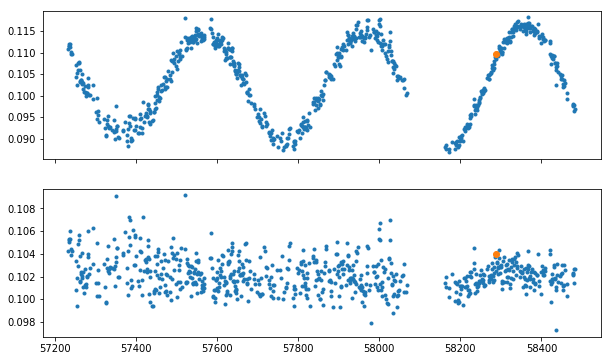

In [7]:
fig,axes=plt.subplots(2,1,sharex=True,figsize=(10,6))
axes[0].plot(bjd,rvb,'.')
axes[0].plot(bjd[iref],rvb[iref],'o')
axes[1].plot(bjd,rvh,'.')
axes[1].plot(bjd[iref],rvh[iref],'o')


### Construct basis

start by fitting reference CCF with Gaussian

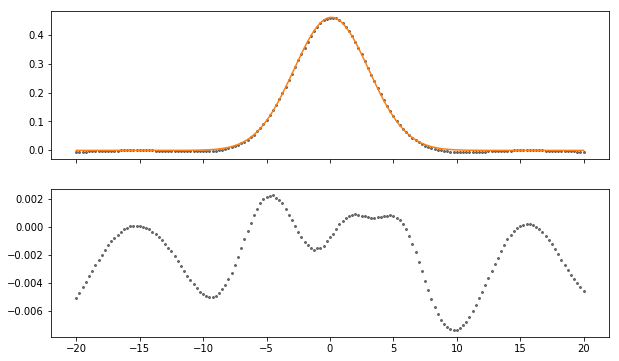

In [8]:
def CCFGauss(p,x):
    return p[0] * exp(-(x-p[1])**2/2.0/p[2]**2)
def nllG(p,x,y):
    r = y - CCFGauss(p,x)
    return (r**2).sum()
p0_gauss = np.array([0.45,0.0,3.5])
soln = minimize(nllG,p0_gauss,args=(x,yref))
p1_gauss = soln.x
g = CCFGauss(p1_gauss,x)
r = yref - g
fig,axes = plt.subplots(2,1,figsize=(10,6),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,g,'C1')
axes[1].plot(x,r, 'k.', ms = 4, alpha = 0.5)


Now construct basis

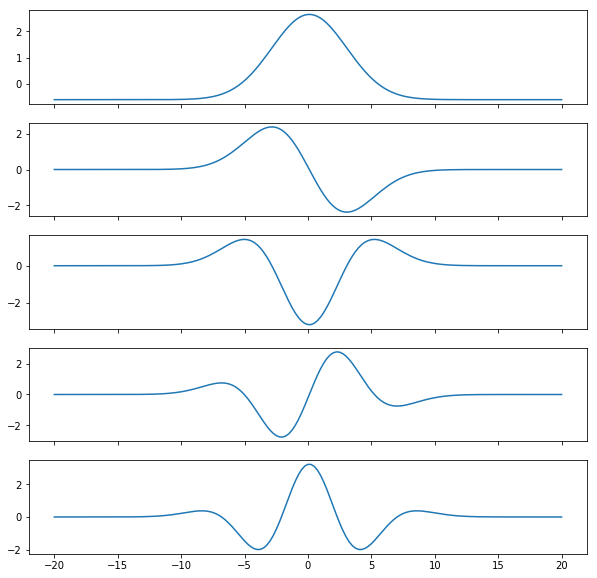

In [10]:
def get_Gauss_basis(params, x, nder, doPlot = False):
    nb = 1 + nder
    nx = len(x)
    basis = np.zeros((nb+1,nx))
    g = CCFGauss(params,x)
    gmean, gstd = g.mean(), g.std()
    basis[0,:] = (g - gmean) / gstd
    dx = x[1] - x[0]
    xder = x[:-1] + 0.5 * dx
    for ider in range(nder):
        der = (g[1:] - g[:-1])
        f = interp1d(xder,der,bounds_error=False,fill_value=0.0)
        g = f(x)
        gmean, gstd = g.mean(), g.std()
        basis[ider+1,:] = (g - gmean) / gstd
    basis[-1,:]=1.0
    if doPlot:
        fig,axes = plt.subplots(nb,1,sharex=True,figsize=(10,2*nb))
        for ib in range(nb):
            axes[ib].plot(x,basis[ib,:])    
    return basis
basis1 = get_Gauss_basis(p1_gauss, x, 4, True)

[ 0.14396126  0.00066024 -0.00033022  0.00084933 -0.0014369   0.08276064]


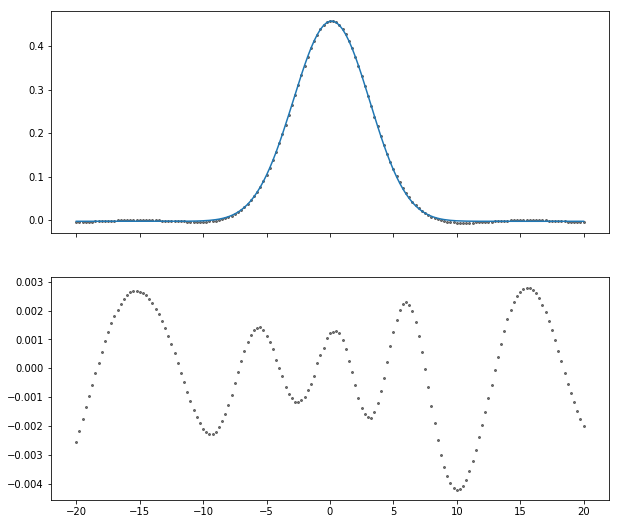

In [11]:
def nllBasis(p,basis,y):
    m = np.dot(p,basis)
    r = y - m
    return (r**2).sum() 
nb = basis1.shape[0]-1
p0 = np.zeros(nb+1)
p0[0] = 1.0
soln = minimize(nllBasis,p0,args=(basis1,yref))
p1 = soln.x
print(p1)
m = np.dot(p1,basis1)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,m)
axes[1].plot(x,yref-m, 'k.', ms = 4, alpha = 0.5)

In [12]:
yfit = np.zeros_like(y)
nobs = y.shape[0]
coeffs1 = np.zeros((nobs,nb+1))
for iobs in range(nobs):
    soln = minimize(nllBasis,p1,args=(basis1,y[iobs,:]))
    yfit[iobs,:] = np.dot(soln.x,basis1)
    coeffs1[iobs,:] = np.copy(soln.x)

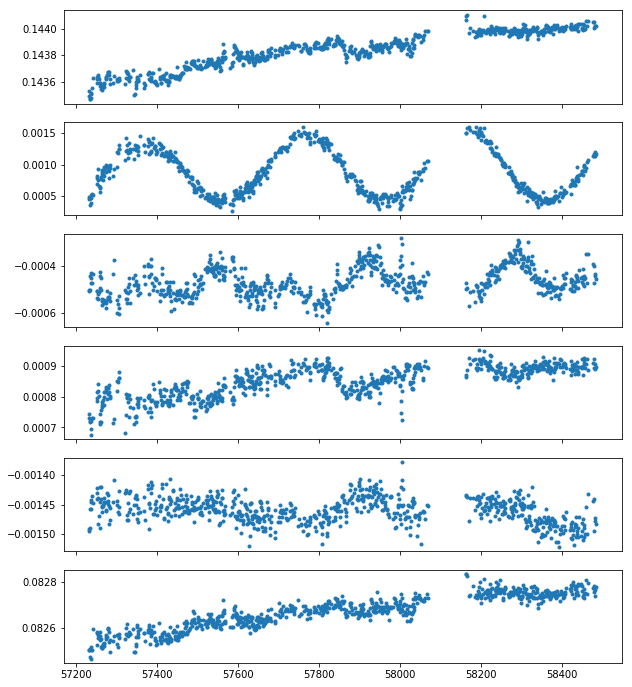

In [13]:
fig,axes = plt.subplots(nb+1,1,sharex=True,figsize=(10,2*(nb+1)))
for ib in range(nb+1):
    axes[ib].plot(bjd,coeffs1[:,ib],'.')    
    

In [14]:
ycor1 = np.zeros_like(y)
ycor2 = np.zeros_like(y)
for iobs in range(nobs):
    cof = np.zeros_like(coeffs1[iobs,:])
    cof[2] = coeffs1[iobs,2]-coeffs1[iref,2]
    cof[3] = coeffs1[iobs,3]-coeffs1[iref,3]
    cof[4] = coeffs1[iobs,4]-coeffs1[iref,4]
    ycor1[iobs,:] = y[iobs,:] - np.dot(cof,basis1)
    cof = np.zeros_like(coeffs1[iobs,:])
    cof[1] = coeffs1[iobs,1]-coeffs1[iref,1]
    ycor2[iobs,:] = y[iobs,:] - np.dot(cof,basis1)
    

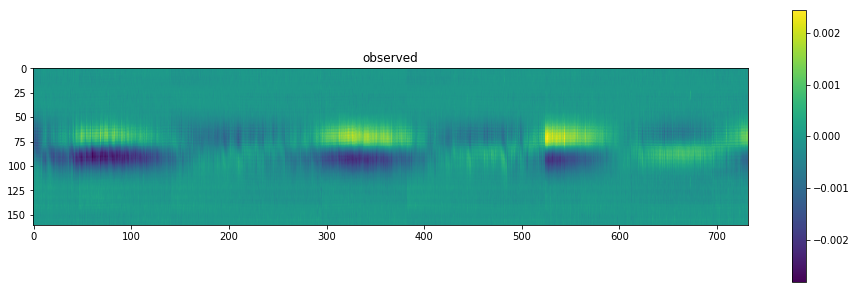

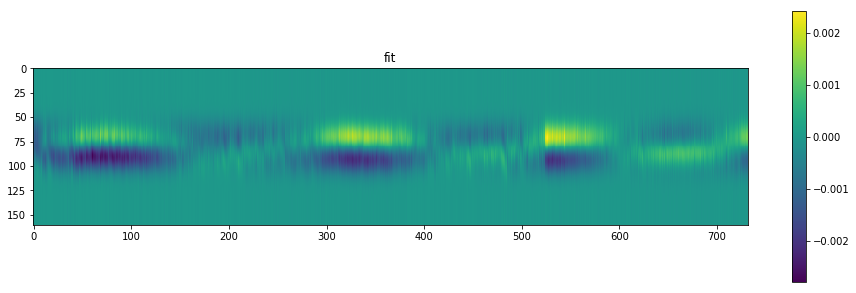

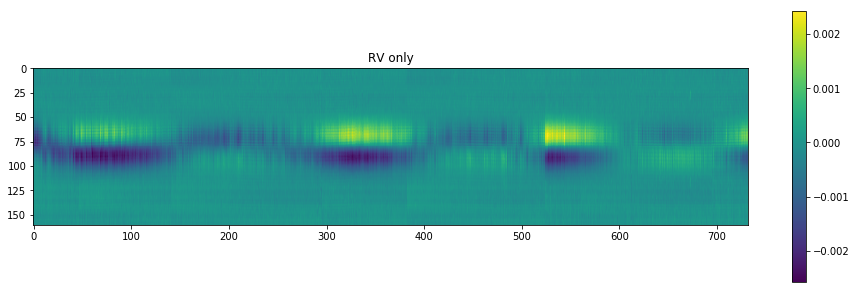

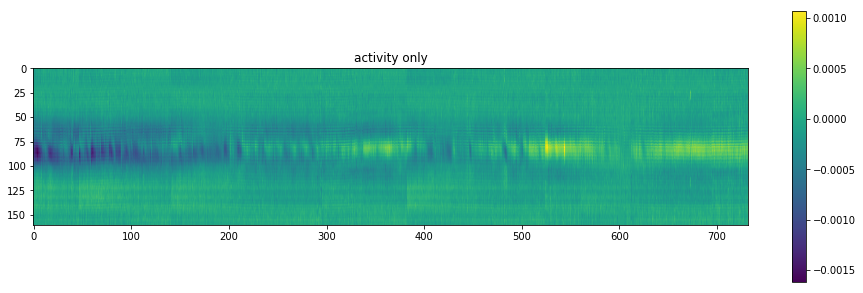

In [15]:
plt.figure(figsize=(16,5))
plt.title('observed')
plt.imshow((y-y[iref,:]).T)
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('fit')
plt.imshow((yfit-yfit[iref,:]).T)
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('RV only')
plt.imshow((ycor1-y[iref,:]).T)
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('activity only')
plt.imshow((ycor2-y[iref,:]).T)
plt.colorbar()

In [16]:
def nll_shift(p,x,y,yref):
    g = interp1d(x,yref,bounds_error=False)
    xs = x - p[0]
    ys = g(xs)
    r = y - ys
    l = np.isfinite(r)
    return (r[l]**2).sum() / l.sum()
g = CCFGauss(p1_gauss,x)
nobs = y.shape[0]
shifts = np.zeros((nobs,3))
for iobs in range(nobs):
    soln = minimize(nllG,p1_gauss,args=(x,y[iobs,:]))
    shifts[iobs,0] = np.copy(soln.x[1])
    soln = minimize(nllG,p1_gauss,args=(x,yfit[iobs,:]))
    shifts[iobs,1] = np.copy(soln.x[1])
    soln = minimize(nllG,p1_gauss,args=(x,ycor1[iobs,:]))
    shifts[iobs,2] = np.copy(soln.x[1])
    print('{:.6f} {:.6f} {:.6f} {:.6f}'.format(rvh[iobs],shifts[iobs,0],shifts[iobs,1],shifts[iobs,2]))

0.104229 0.111377 0.111377 0.113698
0.105337 0.112303 0.112303 0.114387
0.105047 0.114191 0.114192 0.116708
0.105255 0.111510 0.111510 0.114083
0.105993 0.112592 0.112592 0.115998
0.105357 0.111086 0.111086 0.114082
0.103932 0.110151 0.110151 0.112686
0.104396 0.109845 0.109845 0.112140
0.104283 0.110292 0.110292 0.112621
0.103386 0.107156 0.107157 0.108334
0.100789 0.104424 0.104424 0.105070
0.101879 0.104887 0.104888 0.105914
0.099389 0.102412 0.102413 0.102489
0.102972 0.106071 0.106071 0.106653
0.104837 0.108386 0.108387 0.109289
0.105246 0.109600 0.109600 0.111668
0.105679 0.107517 0.107517 0.110104
0.103811 0.107004 0.107004 0.109691
0.101644 0.103559 0.103559 0.106134
0.101526 0.103681 0.103681 0.105461
0.102220 0.101147 0.101147 0.102577
0.102427 0.102337 0.102337 0.103581
0.102055 0.102573 0.102574 0.104143
0.104094 0.105437 0.105438 0.106899
0.101895 0.103083 0.103083 0.104218
0.102417 0.103873 0.103874 0.105299
0.101109 0.101686 0.101686 0.102631
0.100589 0.100985 0.100985 0

0.103372 0.106249 0.106249 0.106397
0.104220 0.108342 0.108342 0.108316
0.102736 0.105536 0.105537 0.105988
0.102108 0.105269 0.105270 0.105292
0.102123 0.104658 0.104658 0.105071
0.102233 0.103115 0.103116 0.102794
0.100283 0.102617 0.102617 0.101859
0.102185 0.103886 0.103886 0.102812
0.103099 0.104911 0.104911 0.104092
0.102336 0.103778 0.103779 0.103230
0.101660 0.103284 0.103285 0.102516
0.102821 0.104757 0.104757 0.104075
0.101769 0.102612 0.102612 0.102153
0.104834 0.105134 0.105134 0.104710
0.104968 0.104909 0.104909 0.105731
0.103475 0.102962 0.102962 0.103387
0.101357 0.101385 0.101385 0.101392
0.101436 0.101163 0.101164 0.100861
0.101789 0.099337 0.099338 0.099030
0.099866 0.099922 0.099922 0.098750
0.101848 0.100046 0.100046 0.098998
0.103414 0.101827 0.101827 0.101400
0.102477 0.099578 0.099579 0.099300
0.100869 0.098702 0.098703 0.098295
0.102227 0.095930 0.095930 0.095860
0.101802 0.097555 0.097556 0.097028
0.101384 0.097187 0.097187 0.097371
0.100673 0.095892 0.095892 0

0.100478 0.088689 0.088689 0.087377
0.100916 0.091767 0.091767 0.090581
0.101214 0.090114 0.090114 0.088672
0.101159 0.090814 0.090814 0.089246
0.099530 0.088058 0.088058 0.086008
0.101895 0.092427 0.092427 0.091033
0.101095 0.092714 0.092714 0.091467
0.101859 0.091974 0.091974 0.090714
0.101597 0.092953 0.092953 0.091744
0.101124 0.093130 0.093130 0.092094
0.102019 0.092555 0.092555 0.091745
0.101208 0.092751 0.092751 0.091487
0.100810 0.092945 0.092945 0.092061
0.100261 0.092731 0.092731 0.091630
0.100496 0.092325 0.092326 0.091275
0.100796 0.093481 0.093481 0.091751
0.102069 0.095107 0.095107 0.093749
0.100525 0.093003 0.093003 0.092109
0.102402 0.095511 0.095511 0.093839
0.101968 0.095400 0.095400 0.094588
0.102412 0.096183 0.096183 0.095353
0.103164 0.097015 0.097016 0.096694
0.104544 0.096722 0.096722 0.096048
0.102632 0.096774 0.096774 0.096564
0.100524 0.096384 0.096384 0.096162
0.101315 0.094155 0.094155 0.093473
0.102198 0.097748 0.097748 0.097160
0.101440 0.097242 0.097242 0

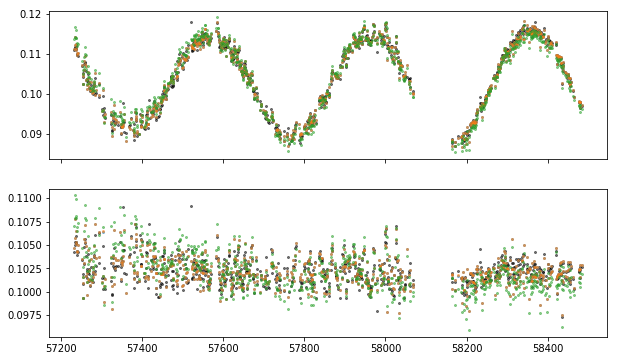

In [17]:
fig,axes = plt.subplots(2,1,figsize=(10,6),sharex = True)
axes[0].plot(bjd,rvb, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(bjd,shifts[:,0], 'C0.', ms = 4, alpha = 0.5)
axes[0].plot(bjd,shifts[:,1], 'C1.', ms = 4, alpha = 0.5)
axes[0].plot(bjd,shifts[:,2], 'C2.', ms = 4, alpha = 0.5)
axes[1].plot(bjd,rvh, 'k.', ms = 4, alpha = 0.5)
axes[1].plot(bjd,shifts[:,0]+bsrv, 'C0.', ms = 4, alpha = 0.5)
axes[1].plot(bjd,shifts[:,1]+bsrv, 'C1.', ms = 4, alpha = 0.5)
axes[1].plot(bjd,shifts[:,2]+bsrv, 'C2.', ms = 4, alpha = 0.5)

### Try the same but using a GP fit to the reference CCF rather than a Gaussian

[  0.08266844 -13.81551056   0.           2.30258509]


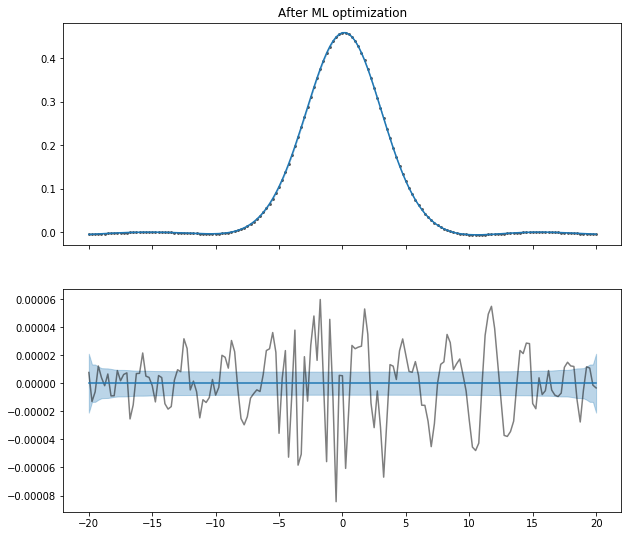

In [18]:
from george import kernels, GP
k = 1.0 * kernels.ExpSquaredKernel(10.0)
gp = GP(k,mean=np.mean(y), fit_mean=True, white_noise = np.log(1e-6), fit_white_noise=True)
print(gp.get_parameter_vector())
def nllGP(p,x,y):
    if (abs(p[2:])>10).any():
        return 1e25        
    gp.set_parameter_vector(p)
    try:
        gp.compute(x)
    except:
        return 1e25
    return -gp.lnlikelihood(y, quiet=True)
p0 = gp.get_parameter_vector()
soln = minimize(nllGP,p0,args=(x,yref))
p1 = soln.x
gp.set_parameter_vector(p1)
mu, var = gp.predict(yref, x, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].set_title('After ML optimization')
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,mu)
axes[0].fill_between(x,mu+std,mu-std,alpha=0.3,color='C0')
axes[1].plot(x,yref-mu, 'k-', ms = 4, alpha = 0.5)
axes[1].plot(x,mu-mu)
axes[1].fill_between(x,std,-std,alpha=0.3,color='C0')

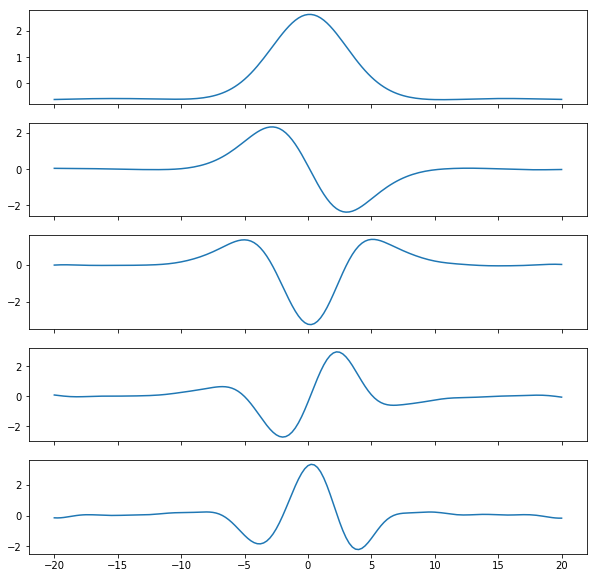

In [20]:
nder = 4
nb = 1 + nder
nvel = len(x)
basis2 = np.zeros((nb+1,nvel))

newp = k.get_parameter_vector()
newp[1] = np.exp(newp[1])
gp.set_parameter('mean:value',0.0)
g = gp.predict(yref,x,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[0,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredPrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[1,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredDoublePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[2,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredTriplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[3,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredQuadruplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis2[4,:] = (g - gmean) / gstd

basis2[-1,:]=1.0

fig,axes = plt.subplots(nb,1,sharex=True,figsize=(10,2*nb))
for ib in range(nb):
    axes[ib].plot(x,basis2[ib,:])    

[ 1.43706729e-01 -3.16216851e-08  3.82277624e-07 -3.15659246e-08
  3.93325523e-07  8.27606354e-02]


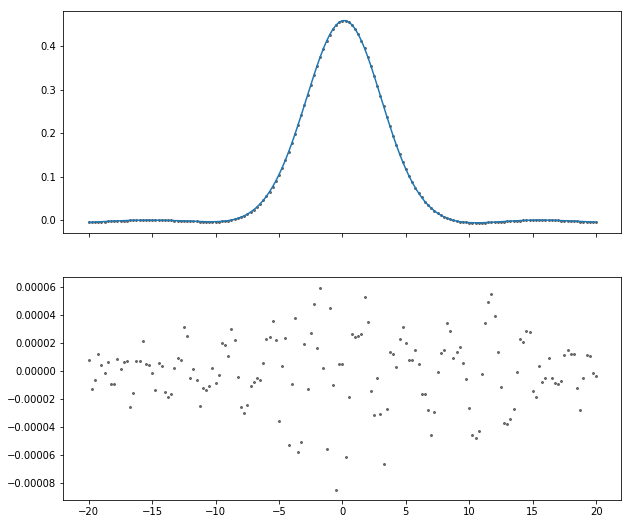

In [21]:
p0 = np.zeros(nb+1)
p0[0] = 1.0
soln = minimize(nllBasis,p0,args=(basis2,yref))
p1 = soln.x
print(p1)
m = np.dot(p1,basis2)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,m)
axes[1].plot(x,yref-m, 'k.', ms = 4, alpha = 0.5)

In [22]:
yfit2 = np.zeros_like(y)
coeffs2 = np.zeros((nobs,nb+1))
for iobs in range(nobs):
    soln = minimize(nllBasis,p1,args=(basis2,y[iobs,:]))
    yfit2[iobs,:] = np.dot(soln.x,basis2)
    coeffs2[iobs,:] = soln.x

-0.002824410123815513 0.0024317886412071887
-0.0027877473579205336 0.0024266965409141528
-0.002826143089192823 0.002415655687429241
-0.0030095245595664344 0.0042711780700988855
-0.0003715816039538966 0.00023647844189415845


Text(0.5, 0, 'vel (km/s)')

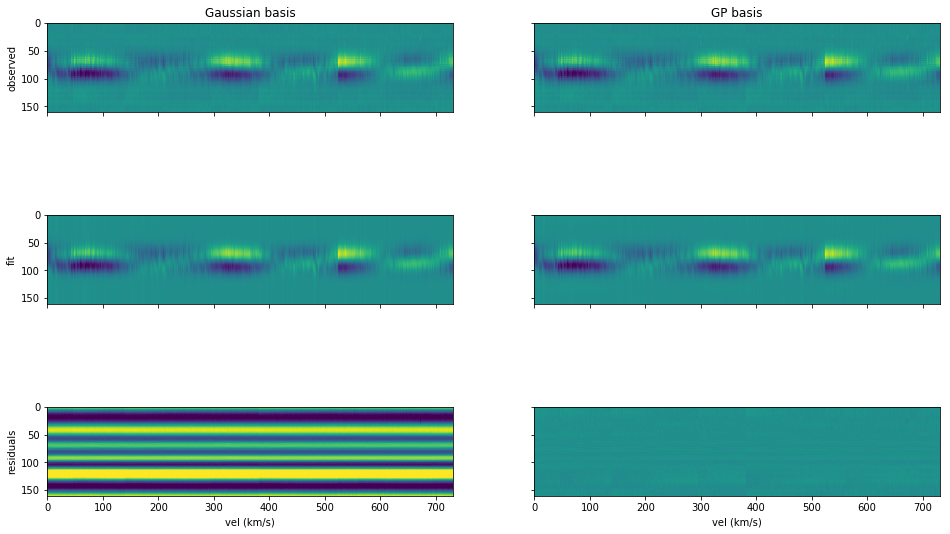

In [33]:
fig,axes=plt.subplots(3,2,figsize=(16,10),sharex=True,sharey=True)
axes[0,0].imshow((y-y[iref,:]).T,vmin=-0.0025,vmax=0.0025)
print((y-y[iref,:]).min(),(y-y[iref,:]).max())
axes[0,0].set_ylabel('observed')
axes[0,0].set_title('Gaussian basis')
axes[0,1].imshow((y-y[iref,:]).T,vmin=-0.0025,vmax=0.0025)
axes[0,1].set_title('GP basis')
axes[1,0].imshow((yfit-yfit[iref,:]).T,vmin=-0.0025,vmax=0.0025)
print((yfit-yfit[iref,:]).min(),(yfit-yfit[iref,:]).max())
axes[1,0].set_ylabel('fit')
axes[1,1].imshow((yfit2-yfit2[iref,:]).T,vmin=-0.0025,vmax=0.0025)
print((yfit2-yfit2[iref,:]).min(),(yfit2-yfit2[iref,:]).max())
axes[2,0].imshow((yfit-y).T,vmin=-0.0025,vmax=0.0025)
print((yfit-y).min(),(yfit-y[iref,:]).max())
axes[2,0].set_ylabel('residuals')
axes[2,0].set_xlabel('vel (km/s)')
axes[2,1].imshow((yfit2-y).T,vmin=-0.0025,vmax=0.0025)
print((yfit2-y).min(),(yfit2-y).max())
axes[2,1].set_xlabel('vel (km/s)')

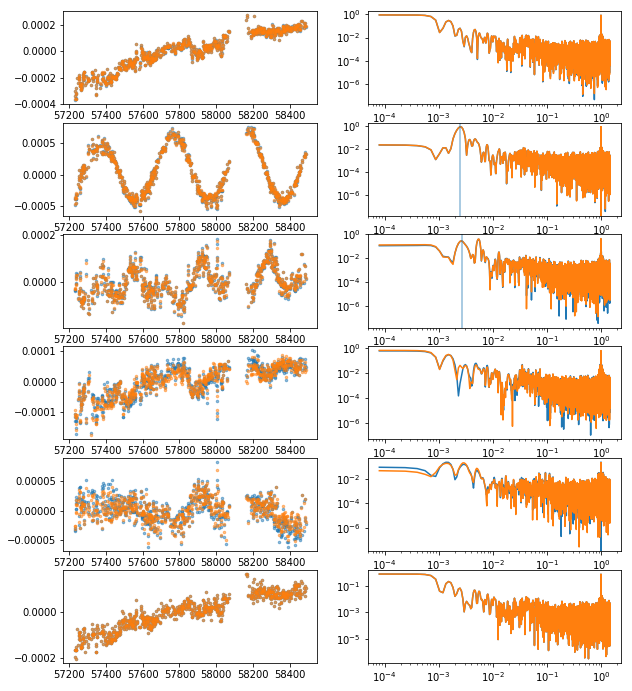

In [26]:
from astropy.stats import LombScargle
fig,axes = plt.subplots(nb+1,2,figsize=(10,2*(nb+1)))
for ib in range(nb+1):
    axes[ib,0].plot(bjd,coeffs1[:,ib]-np.mean(coeffs1[:,ib]),'C0.',ms=5,alpha=0.5)    
    axes[ib,0].plot(bjd,coeffs2[:,ib]-np.mean(coeffs2[:,ib]),'C1.',ms=5,alpha=0.5) 
    frequency, power = LombScargle(bjd, coeffs1[:,ib]).autopower()
    axes[ib,1].plot(frequency,power)
    frequency, power = LombScargle(bjd, coeffs2[:,ib]).autopower()
    axes[ib,1].plot(frequency,power)    
    axes[ib,1].loglog()
    if ib == 1:
        axes[ib,1].axvline(1/399.,alpha=0.5)
    if ib == 2:
        axes[ib,1].axvline(1/365.,alpha=0.5)    

At this stage I have to think about what to do next. Two options present themselves. 

One is to use the coefficients of the linear basis model as new activity indicators and incorporate them into a model similar to Vinesh's GP framework. I would probably need Oscar's help to implement it. 

The other option would be to analyse synthetic time-series of CCFs produced using SOAP2.0 and examine the behaviour of the coefficients of the different basis terms for spot, faculae, and Doppler shifts separately, in the hope that this might lead to new insights. I should probably do both!

In [36]:
np.savetxt('HARPSN_Solar_CCF_coeffs_GP.txt',coeffs2)

In [37]:
np.savetxt('HARPSN_Solar_CCF_coeffs_Gauss.txt',coeffs1)